In [1]:
import hdbscan
import apache_beam as beam
import numpy as np
import pandas as pd

import torch

from sklearn.model_selection import train_test_split
from apache_beam import dataframe
from apache_beam.ml.inference.base import RunInference, PredictionResult
from apache_beam.ml.inference.sklearn_inference import SklearnModelHandlerNumpy
from apache_beam.ml.inference.sklearn_inference import ModelFileType
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerTensor, _convert_to_result
from apache_beam.ml.inference.base import KeyedModelHandler
from autoembedder import Autoembedder
import apache_beam.runners.interactive.interactive_beam as ib

In [2]:
ib.options.num = '10m'

In [4]:
# data = pd.read_csv('../data/dtc_opportunity.csv')
# train, test = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)
# train.to_csv('../data/dtc_opportunity_train.csv', index=False)
# test.to_csv('../data/dtc_opportunity_test.csv', index=False)
# # Uncomment for data split

In [5]:
train = pd.read_csv('../data/dtc_opportunity_train.csv')
test = pd.read_csv('../data/dtc_opportunity_test.csv')

### Custom wrappers for embedding and clustering models
These custom handlers are used to determine the way the data processed before the input to RunInference:
1. For anomaly detection model
2. For PyTorch model

In [5]:
class CustomSklearnModelHandlerNumpy(SklearnModelHandlerNumpy):
    def run_inference(self, batch, model, inference_args=None):
        predictions = hdbscan.approximate_predict(model, batch)
        return [PredictionResult(x, y) for x, y in zip(batch, predictions[0])]

In [6]:
class CustomPytorchModelHandlerTensor(PytorchModelHandlerTensor):
    def run_inference(self, batch, model, inference_args=None):

        with torch.no_grad():
            list_of_cont_tensors = []
            list_of_cat_tensors = []
            for item in batch:
                # print(item['cont_cols'].shape)
                # print(item['cat_cols'].shape)
                list_of_cont_tensors.append(item['cont_cols'])
                list_of_cat_tensors.append(item['cat_cols'])


            batched_tensors_cont = torch.hstack(list_of_cont_tensors)
            batched_tensors_cat = torch.hstack(list_of_cat_tensors)

            # print(batched_tensors_cont)
            # print(batched_tensors_cat.shape)

            model(x_cont=batched_tensors_cont, x_cat=batched_tensors_cat)
            predictions = model.code_value
            return _convert_to_result(batch, predictions)

    def get_num_bytes(self, batch) -> int:
        return sum((el[key].element_size() for el in batch for key in el.keys()))

#### Decode predictions ParDo
returns dict results

In [7]:
class DecodePrediction(beam.DoFn):
    def process(self, element):
        uid, prediction = element
        cluster = prediction.inference.tolist()
        bq_dict = {"id": uid, "cluster": cluster}
        yield bq_dict

Define model parameters

In [8]:
parameters = {
    "hidden_layers": [[25, 20], [20, 10]],
    "epochs": 10,
    "lr": 0.0001,
    "verbose": 1,
    "batch_size": 16,
}
list_cat = [(64, 32)]
num_cont_features = 1

In [9]:
anomaly_detection_model_handler = CustomSklearnModelHandlerNumpy(model_uri='pretrained/anomaly_detection.model',
                                                                 model_file_type=ModelFileType.JOBLIB)

encoder_handler = CustomPytorchModelHandlerTensor(state_dict_path='pretrained/encoder.pth',
                                            model_class=Autoembedder, model_params={'config': parameters, 'num_cont_features': num_cont_features, 'embedding_sizes': list_cat})

In [10]:
import category_encoders as ce
import time
hasher = ce.HashingEncoder(n_components=64, max_process=1, max_sample=1)

def encode_and_normalize(bq_row, hasher=hasher, num_fields=None, id_field='Id'):
    if num_fields is None:
        num_fields = ['Amount']

    amount_mean = 1137889.913561848
    amount_std = 1197302.0975264315


    target_list = [getattr(bq_row, feature_name) for feature_name in set(bq_row._fields)-set(num_fields)-set(id_field)]
    start_t = time.time()
    hashed_list = hasher.fit_transform(np.asarray([target_list]))
    print(f'hash took {time.time() - start_t}')
    result = (getattr(bq_row, id_field),
              {'cont_cols': torch.Tensor([(getattr(bq_row, x)-amount_mean)/amount_std for x in num_fields]).reshape(-1, 1),
            'cat_cols': torch.Tensor(hashed_list.to_numpy().reshape(-1, 1))})
    return result

Construct and run the pipeline

In [12]:
def process_with_pipeline(data_csv):
    with beam.Pipeline(InteractiveRunner()) as p:
        input_data = p | "Read CSV" >> beam.dataframe.io.read_csv(data_csv)
        # For now dropping dates
        input_data = input_data.drop(['Billing State/Province',
                                      'Created Date',
                                      'Close Date',
                                      'Account Name',
                                      'Product Name',
                                      'Opportunity Name',
                                      'Opportunity Owner',
                                      'Account Owner'], axis=1)
        input_data = input_data.drop('#', axis=1)
        input_data = input_data.replace('-', '', regex=True)
        input_data = input_data.replace('/', '', regex=True)
        input_data = input_data.replace(' ', '', regex=True)
        input_data = input_data.rename(columns={x: x.replace(' ', '') for x in input_data.columns})
        input_data['Id'] = input_data.index
        input_data = beam.dataframe.convert.to_pcollection(input_data)

        keyed_anomalies = (
                input_data
                | beam.Map(encode_and_normalize)
                | "Encode" >> RunInference(model_handler=KeyedModelHandler(encoder_handler))
                | "Concat features" >> beam.Map(lambda x: (x[0], x[1].inference.detach().numpy()))
                | "Detect anomaly" >> RunInference(model_handler=KeyedModelHandler(anomaly_detection_model_handler))
                | "Get predictions" >> beam.ParDo(DecodePrediction())
                | "Write output" >> beam.io.textio.WriteToText(file_path_prefix='prediction_output/shard')
        )

        return keyed_anomalies

Run the pipeline on the test data

In [11]:
process_with_pipeline(data_csv='dtc_opportunity_test.csv')

NameError: name 'process_with_pipeline' is not defined

Display the data

In [14]:
import json
result = []
with open("prediction_output/shard-00000-of-00001") as f:
    for line in f:
        line = line.replace("'", '"')
        result.append(json.loads(line))

In [15]:
result_df = pd.DataFrame.from_dict(result)

<AxesSubplot: xlabel='cluster'>

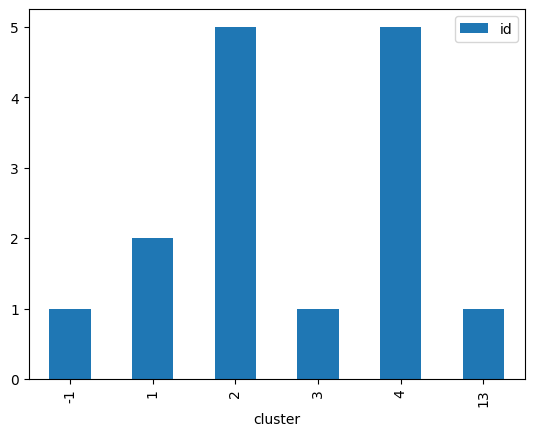

In [16]:
result_df.groupby([result_df['cluster']]).count().plot(kind='bar')

In [17]:
pd.read_csv('dtc_opportunity_test.csv').iloc[:16].to_csv('dtc_opportunity_test_low.csv', index=False)